In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pyvi import ViTokenizer, ViUtils
import pickle
from tqdm.notebook import tqdm_notebook as tqdm
import time

2023-01-05 14:27:28.206274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 14:27:29.222952: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-05 14:27:29.223069: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-05 14:27:29.223083: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

### Load data

In [3]:
df = pd.read_csv('data.csv',sep=';')
df.head()

,Date,Time,Name,Link,Content,Sentiment,Entity
0,01/01/2022,9:21,Hoàng Xuân Hoà,https://www.facebook.com/2389056107900844_2389...,Ib nha e,Trung lập,Goldmark City
1,01/01/2022,9:44,Tạ Hồng,https://www.facebook.com/2389056107900844_2389...,Quá đẹp !,Tích cực,Goldmark City
2,01/01/2022,9:55,Trịnh Hồng Sương,https://www.facebook.com/2389056107900844_2389...,Ib em nhed,Trung lập,Goldmark City
3,01/01/2022,17:10,Nguyễn Chính,https://www.facebook.com/2389056107900844_2389...,Đẹp quá,Tích cực,Goldmark City
4,01/01/2022,10:16,Đinh Điềm,https://www.facebook.com/1995922247237355_1996...,Văn Thủy còn ở golmax ko ra ngõ 4 hàm nghi Cafe,Trung lập,Goldmark City


In [4]:
# Feature selection
sentiment_data = pd.DataFrame({'input':df['Content'],'label':df['Sentiment']})
sentiment_data.head()

,input,label
0,Ib nha e,Trung lập
1,Quá đẹp !,Tích cực
2,Ib em nhed,Trung lập
3,Đẹp quá,Tích cực
4,Văn Thủy còn ở golmax ko ra ngõ 4 hàm nghi Cafe,Trung lập


### Preprocessing

In [6]:
# Tokenization vietnamese
input_data = sentiment_data['input'].values
input_label = sentiment_data['label'].values

label_dict={'Tiêu cực':0,'Trung lập':1,'Tích cực':2}

input_pre=[]
label_with_accent=[]

for idx, dt in tqdm(enumerate(input_data),desc='Progress bar'):
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
    input_text_pre = ' '.join(input_text_pre)
    input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode('utf-8'))
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)
    input_pre.append(input_text_pre_accent)
    input_pre.append(input_text_pre_no_accent)
    label_with_accent.append(input_label[idx])
    label_with_accent.append(input_label[idx])

Progress bar: 0it [00:00, ?it/s]

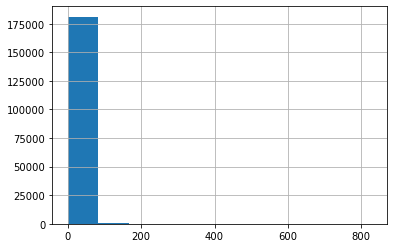

In [7]:
# Exploratory Data
seq_len = [len(i.split()) for i in input_pre]
pd.Series(seq_len).hist(bins=10)
plt.show()

In [8]:
# Tokenization tenserflow
label_idx = [label_dict[i] for i in label_with_accent]
label_tf = tf.keras.utils.to_categorical(label_idx,num_classes=3,dtype='float32')

tokenizer_data = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>',filters='',split=' ')
tokenizer_data.fit_on_texts(input_pre)

tokenizer_data_text = tokenizer_data.texts_to_sequences(input_pre)
vec_data = tf.keras.preprocessing.sequence.pad_sequences(tokenizer_data_text,padding='post',maxlen=256)

pickle.dump(tokenizer_data,open('tokenizer_data.pkl','wb'))
print('input data shape',vec_data.shape)
data_vocab_size = len(tokenizer_data.word_index)+1
print('data vocab size:',data_vocab_size)

input data shape (181566, 256)
data vocab size: 37994


In [9]:
# Split data to training set and validation
X_train, X_val, y_train, y_val = train_test_split(vec_data,label_tf,test_size=0.2,random_state=999)
print('Training data:',len(X_train))
print('Validation data:',len(X_val))

Training data: 145252
Validation data: 36314


### Modeling

In [10]:
class RNNCell(tf.keras.layers.Layer):
    def __init__(self, units,**kwargs):
        self.units = units
        self.state_size = units
        super(RNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='GlorotNormal',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer='GlorotNormal',
            name='recurrent_kernel')
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        h = tf.keras.backend.dot(inputs, self.kernel)
        output = h + tf.keras.backend.dot(prev_output, self.recurrent_kernel)
        return output, [output]

    def get_config(self):
        config = super().get_config()
        config.update({
            "units": self.units,
            "units": self.state_size})
        return config

In [ ]:
def rnn_model():
    dropout_threshold = 0.4
    input_dim = data_vocab_size
    output_dim = 32
    input_length = 256
    intitializer = tf.keras.initializers.GlorotNormal()

    input_layer = tf.keras.layers.Input((input_length))
    feature = tf.keras.layers.Embedding(input_dim=input_dim,output_dim=output_dim,input_length=input_length,embeddings_initializer='GlorotNormal')(input_layer)
    
    #RNN
    cell = RNNCell(32)
    rnn_feature = tf.keras.layers.RNN(cell,return_sequences=True)(feature)
    #rnn_feature = tf.keras.layers.MaxPooling1D()(rnn_feature)
    #rnn_feature = tf.keras.layers.Dropout(dropout_threshold)(rnn_feature)
    #rnn_feature = tf.keras.layers.RNN(cell,return_sequences=True)(rnn_feature)
    rnn_feature = tf.keras.layers.MaxPooling1D()(rnn_feature)
    rnn_feature = tf.keras.layers.LayerNormalization()(rnn_feature)
    rnn_feature = tf.keras.layers.Dropout(dropout_threshold)(rnn_feature)

    input_feature = tf.keras.layers.GlobalMaxPooling1D()(rnn_feature)
    input_feature = tf.keras.layers.LayerNormalization()(input_feature)

    classifier = tf.keras.layers.Dense(90,activation = 'relu')(input_feature)
    classifier = tf.keras.layers.Dropout(0.2)(classifier)
    classifier = tf.keras.layers.Dense(70,activation = 'relu')(classifier)
    classifier = tf.keras.layers.Dropout(0.2)(classifier)
    classifier = tf.keras.layers.Dense(50,activation = 'relu')(classifier)
    classifier = tf.keras.layers.Dropout(0.2)(classifier)
    classifier = tf.keras.layers.Dense(30,activation = 'relu')(classifier)
    classifier = tf.keras.layers.Dropout(0.2)(classifier)
    classifier = tf.keras.layers.Dense(3,activation = 'softmax')(classifier)

    model = tf.keras.Model(inputs = input_layer, outputs = classifier)

    return model

rnn = rnn_model()
config = model.get_config()
custom_objects = {"RNNCell": RNNCell}
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))